# Steam Game Positivity Prediction

Questions to answer:

What makes a “good game”?
What, if any, factors contributes to a game getting a good rating?
What attributes of a Games Store page contribute to its success?


Lets start by getting the needed packages and the data

In [168]:
import kagglehub
import pandas as pd
import os
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import re
import string
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline


In [127]:
# Download dataset
path = kagglehub.dataset_download("fronkongames/steam-games-dataset")
print("Path to dataset files:", path)

# Find CSV file
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)

# Read and patch the file
with open(csv_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Fix the broken header (only applies to first line usually)
lines[0] = lines[0].replace("DiscountDLC count", "Discount,DLC count")

# Load the fixed content into a DataFrame
df_raw = pd.read_csv(io.StringIO(''.join(lines)))

Path to dataset files: C:\Users\wille\.cache\kagglehub\datasets\fronkongames\steam-games-dataset\versions\30


These are some helper functions to help with cleaning the data

In [128]:
def normalize_label(label):
    if not isinstance(label, str):
        return label
    label = label.strip().lower()                       # lowercase and trim whitespace
    label = label.strip(string.punctuation)             # remove punctuation from start/end
    label = re.sub(r'\s+', ' ', label)                  # collapse multiple spaces
    return label

def clean_list_items(items):
    cleaned = []
    for item in items:
        if not item:
            continue
        item_clean = item.strip()
        item_clean = re.sub(r"^[\[\('\"]+|[\]\)'\"]+$", "", item_clean)
        item_clean = normalize_label(item_clean)
        if item_clean:
            cleaned.append(item_clean)
    return cleaned

def parse_comma_separated_list(x):
    if isinstance(x, list):
        return clean_list_items(x)
    if isinstance(x, str):
        items = [item.strip() for item in x.split(',') if item.strip()]
        return clean_list_items(items)
    return []

def filter_valid_target(df, target_column):
    # Keep only rows where target is not 0 and not NaN
    filtered_df = df[(df[target_column].notna()) & (df[target_column] != 0)]
    
    print(f"Total rows with valid '{target_column}': {len(filtered_df)}")
    return filtered_df

def filter_unrated_reviews(df, category_column='Review_Category'):
    filtered_df = df[df[category_column] != "Unrated"]
    print(f"Rows with rated reviews: {len(filtered_df)} (Removed {len(df) - len(filtered_df)} unrated rows)")
    return filtered_df

def flatten_and_split_language_list(x):
    import re

    flattened = []

    if isinstance(x, list):
        for item in x:
            if isinstance(item, list):
                flattened.extend(item)
            elif isinstance(item, str):
                # Split by newline or comma
                parts = re.split(r'[\r\n,]+', item)
                flattened.extend(parts)
            else:
                flattened.append(item)

    elif isinstance(x, str):
        # Split by newline or comma
        flattened = re.split(r'[\r\n,]+', x)

    # Clean and normalize
    result = clean_list_items(flattened)

    # Warn if any residual newline characters remain
    for r in result:
        if r and ('\n' in r or '\r' in r):
            print(f"⚠️ Warning: Unclean label detected -> {repr(r)}")

    return result
    
def filter_outliers(df, feature, target, lower_percentile=0.01, upper_percentile=0.99):
    lower_f = df[feature].quantile(lower_percentile)
    upper_f = df[feature].quantile(upper_percentile)
    lower_t = df[target].quantile(lower_percentile)
    upper_t = df[target].quantile(upper_percentile)
    
    return df[(df[feature] >= lower_f) & (df[feature] <= upper_f) &
              (df[target] >= lower_t) & (df[target] <= upper_t)]

def filter_outliers_iqr(df, column, drop_zeros=False):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    if drop_zeros:
        filtered = filtered[filtered[column] > 0]
    return filtered

def count_screenshots(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return value.count("http")
    if isinstance(value, list):
        return len(value)
    return 0


def count_movies(value):
    if pd.isna(value):
        return 0
    # Try to evaluate stringified list/dicts safely
    if isinstance(value, str):
        try:
            value = ast.literal_eval(value)
        except Exception:
            # Fallback: count URLs
            return value.count("http")
    if isinstance(value, list):
        return len(value)
    return 0


Lets take a look at the data a bit

In [129]:
print("================Basic Info======================")

print(df_raw.info)

print("================Table Shape======================")

rows, cols = df_raw.shape
print(f"Rows: {rows}, Columns: {cols}")

print("================Table Head======================")
      
print(df_raw.head(4))

max_x_row = df_raw.loc[df_raw['Negative'].idxmax()]

# Print the game's name and X count
print(f"Game with most Xs: {max_x_row['Name']} ({max_x_row['Negative']} X)")

================Basic Info======================
<bound method DataFrame.info of           AppID                     Name  Release date Estimated owners  \
0         20200         Galactic Bowling  Oct 21, 2008        0 - 20000   
1        655370             Train Bandit  Oct 12, 2017        0 - 20000   
2       1732930             Jolt Project  Nov 17, 2021        0 - 20000   
3       1355720                 Henosis™  Jul 23, 2020        0 - 20000   
4       1139950    Two Weeks in Painland   Feb 3, 2020        0 - 20000   
...         ...                      ...           ...              ...   
111447  3600970          Paragon Of Time  Apr 10, 2025        0 - 20000   
111448  3543710  A Few Days With : Hazel  Apr 11, 2025        0 - 20000   
111449  3265370                 MosGhost   Apr 1, 2025        0 - 20000   
111450  3423620               AccuBow VR  Mar 11, 2025            0 - 0   
111451  3183790   Defense Of Fort Burton  Apr 10, 2025        0 - 20000   

        Peak CCU  

In [130]:
#I wanted to see which columns had the most Nan values

nan_counts = df_raw.isna().sum().sort_values(ascending=False)
print(nan_counts[nan_counts > 0])

Score rank        111408
Metacritic url    107447
Reviews           100828
Notes              93003
Website            64994
Support url        60693
Tags               37423
Support email      19025
Movies              9620
Categories          7566
Publishers          6778
About the game      6483
Developers          6475
Genres              6440
Screenshots         4192
Name                   6
dtype: int64


Now we clean the data. I remove un wanted features, fix the columns, remove Nans, and other stuff

In [131]:
#There are a few duplicate titles. I get rid of them and only take the first one
duplicate_names = df_raw[df_raw.duplicated(subset='Name', keep=False)]
print(f"Found {duplicate_names.shape[0]} rows with duplicate names.")
df_raw = df_raw.drop_duplicates(subset='Name', keep='first')

#Lets add some features
df_raw['Title length'] = df_raw['Name'].astype(str).apply(len)
df_raw['Title_word_count'] = df_raw['Name'].astype(str).apply(lambda x: len(x.split()))
df_raw['Title_avg_word_len'] = df_raw['Name'].astype(str).apply(lambda x: (sum(len(word) for word in x.split()) / max(len(x.split()), 1)))
df_raw['Title Has Number'] = df_raw['Name'].astype(str).apply(lambda x: int(any(char.isdigit() for char in x)))
df_raw['Title_First_Letter'] = df_raw['Name'].astype(str).str[0].str.upper().fillna('Unknown')
df_raw['HasWebsite'] = df_raw['Website'].notna().astype(int)
df_raw['HasSupport'] = (df_raw['Support email'].notna() | df_raw['Website'].notna()).astype(int)
df_raw['Description length'] = df_raw['About the game'].astype(str).apply(len)
df_raw['Description_word_count'] = df_raw['About the game'].astype(str).apply(lambda x: len(x.split()))
df_raw['Description_First_Letter'] = df_raw['About the game'].astype(str).str[0].str.upper().fillna('Unknown')
df_raw['Num_Screenshots'] = df_raw['Screenshots'].apply(count_screenshots)
df_raw['Num_Movies'] = df_raw['Movies'].apply(count_movies)
df_raw['Description_punct_count'] = df_raw['About the game'].astype(str).apply(lambda x: sum(ch in string.punctuation for ch in x))

# One-hot encode the first-letter columns
df_raw = pd.get_dummies(df_raw, columns=['Title_First_Letter', 'Description_First_Letter'],
                        prefix=['TitleLetter', 'DescLetter'], dtype=int)

#Lets drop these columns
drop_cols = ['AppID', 'Screenshots', 'Movies', 'Header image', 'Support email', 'Support url',
             'Website', 'Notes', 'Metacritic url', 'Discount', 'Score rank', 'Reviews',
             'About the game', 'Name', 'Average playtime two weeks', 'Median playtime two weeks', 
             'Median playtime forever' ,'Peak CCU', 'User score', 'Recommendations']
df = df_raw.drop(columns=drop_cols)

#I change the date to simply the year
df['Release date'] = pd.to_datetime(df['Release date'], errors='coerce')
df['Release_year'] = df['Release date'].dt.year.fillna(0).astype(int)
reference_date = pd.Timestamp("2023-07-04")     #When the data ends
df['Days_since_release'] = (reference_date - df['Release date']).dt.days

# Drop original date column
df.drop(columns=['Release date'], inplace=True)

# Lets make sure these columns are correct Numeric columns
df['Positive'] = pd.to_numeric(df['Positive'], errors='coerce')     # Number of positive reviews
df['Negative'] = pd.to_numeric(df['Negative'], errors='coerce')     # Number of negative reviews
df['Required age'] = pd.to_numeric(df['Required age'], errors='coerce')     # Age requirement
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')                   # Game price
df['Average playtime forever'] = pd.to_numeric(df['Average playtime forever'], errors='coerce')     # Avg total playtime for all users
df['Metacritic score'] = pd.to_numeric(df['Metacritic score'], errors='coerce')             # Score from Metacritic, 0 if it does not exist
df['DLC count'] = pd.to_numeric(df['DLC count'], errors='coerce') 
df['Achievements'] = pd.to_numeric(df['Achievements'], errors='coerce')     

#Lets change the Boolean values to ints
bool_features = ['Windows', 'Mac', 'Linux']     #If they're supported by these systems
df[bool_features] = df[bool_features].astype(int)
df['PlatformSupport_count'] = df[bool_features].sum(axis=1)     #Total number of systems the game is supported on

# Drop rows with no rating data, as zero here means no information
df = df[
    (df['Positive'] > 0) &
    (df['Negative'] > 0) 
]

# Create PositivityRate column as well as total number of reviews column and review categories
df['Number Of Reviews'] = (df['Positive'] + df['Negative'])
df['PositivityRate'] = df['Positive'] / df['Number Of Reviews']
df['PositivityRate'] = df['PositivityRate'].fillna(0)
df['Review_Difference'] = df['Positive'] - df['Negative']
df['Review_Difference'] = df['Review_Difference'].replace([np.inf, -np.inf], np.nan)

def get_review_category(row):
    total = row['Number Of Reviews']
    perc = row['PositivityRate']
    
    # Handle missing or invalid data
    if pd.isna(perc):
        return "Unrated"

    if total >= 500:
        if perc >= 0.95:
            return "Overwhelmingly Positive"
        elif perc >= 0.8:
            return "Very Positive"
        elif perc >= 0.7:
            return "Mostly Positive"
        elif perc >= 0.4:
            return "Mixed"
        elif perc < 0.2:
            return "Overwhelmingly Negative"
        else:
            return "Very Negative"

    elif 50 <= total < 500:
        if perc >= 0.8:
            return "Very Positive"
        elif perc >= 0.7:
            return "Mostly Positive"
        elif perc >= 0.4:
            return "Mixed"
        elif perc < 0.2:
            return "Very Negative"
        else:
            return "Negative"

    elif 10 <= total < 50:
        if perc >= 0.8:
            return "Positive"
        elif perc >= 0.7:
            return "Mostly Positive"
        elif perc >= 0.4:
            return "Mixed"
        elif perc < 0.2:
            return "Negative"
        else:
            return "Unrated"

    return "Unrated"

df['Review_Category'] = df.apply(get_review_category, axis=1)

def get_review_category_simplified(row):
    perc = row['PositivityRate']
    total = row['Number Of Reviews']
    
    # Handle missing or invalid data
    if pd.isna(perc):
        return "Unrated"

    # Main simplified categories
    if(total >= 10):
        if perc >= 0.8:
            return "Positive"
        elif perc >= 0.7:
            return "Mostly Positive"
        elif perc >= 0.4:
            return "Mixed"
        elif perc >= 0.2:
            return "Mostly Negative"
        else:
            return "Negative"
    else:
        return "Unrated"

df['Review_Category_Simplified'] = df.apply(get_review_category_simplified, axis=1)

# Apply the function to Supported and Full audio languages
df['Supported languages'] = df['Supported languages'].apply(flatten_and_split_language_list)
df['Full audio languages'] = df['Full audio languages'].apply(flatten_and_split_language_list)

# Combine and count unique languages
df['Languages'] = df.apply(lambda row: list(set(row['Supported languages'] + row['Full audio languages'])), axis=1)
df.drop(columns=['Supported languages', 'Full audio languages'], inplace=True)

# One-hot encode the top 100 categorical features, place the rest in "other"
important_category_count = 100

list_like_features = ['Languages', 'Categories', 'Genres', 'Tags', 'Developers', 'Publishers']
for col in list_like_features:
    df[col] = df[col].apply(parse_comma_separated_list)
    df[f'{col}_count'] = df[col].apply(len)

df['Languages_count'] = df['Languages'].apply(len)

mlb_dict = {}

def get_top_n_labels(series, n):
    all_labels = series.explode()
    top_labels = all_labels.value_counts().head(n).index.tolist()
    return set(top_labels)

for col in list_like_features:
    df[col] = df[col].map(lambda x: x if isinstance(x, list) else [])
    
    top_labels = get_top_n_labels(df[col], n = important_category_count)

    # Filter each list to contain only top labels
    df[f"{col}_filtered"] = df[col].apply(
    lambda x: [item for item in x if item in top_labels] +
              ([f"{col}_Other"] if any(item not in top_labels for item in x) else [])
    )

    mlb = MultiLabelBinarizer()
    transformed = mlb.fit_transform(df[f"{col}_filtered"])
    ohe_cols = [f"{col}_{cls}" for cls in mlb.classes_]

    df_ohe = pd.DataFrame(transformed, columns=ohe_cols, index=df.index)
    df = pd.concat([df, df_ohe], axis=1)

    mlb_dict[col] = mlb

# drop the intermediate filtered columns
df.drop(columns=[f"{col}_filtered" for col in list_like_features], inplace=True)
# Drop the original list-like columns
df.drop(columns=list_like_features, inplace=True)

#Remove similar genre and tags, as a lot of the tags and genres are the same

# Step 1: Identify Genre_ and Tag_ columns
genre_cols = [col for col in df.columns if col.startswith("Genres: ")]
tag_cols = [col for col in df.columns if col.startswith("Tags: ")]
# Step 2: Normalize suffixes (e.g., "Genres_Action" → "action")
genre_suffixes = {col.split("Genres: ")[1]: col for col in genre_cols}
tag_suffixes = {col.split("Tags: ")[1]: col for col in tag_cols}
# Step 3: Find overlapping suffixes
common_suffixes = set(genre_suffixes.keys()) & set(tag_suffixes.keys())
# Step 4: Merge common tags and genres
for suffix in common_suffixes:
    new_col = f"Genre: {suffix}"
    # If the column name already exists, modify it to avoid overwriting
    if new_col in df.columns:
        new_col += "_merged"
    
    df[new_col] = df[genre_suffixes[suffix]] | df[tag_suffixes[suffix]]  # OR logic to combine
    df.drop(columns=[genre_suffixes[suffix], tag_suffixes[suffix]], inplace=True)
# Step 5: Rename remaining unique genres/tags
for suffix in set(genre_suffixes.keys()) - common_suffixes:
    df.rename(columns={genre_suffixes[suffix]: f"Genre: {suffix}"}, inplace=True)
for suffix in set(tag_suffixes.keys()) - common_suffixes:
    df.rename(columns={tag_suffixes[suffix]: f"Genre: {suffix}"}, inplace=True)

#Lets count a few of the categorical features for extra information
df['Categories_count'] = pd.to_numeric(df['Categories_count'], errors='coerce')
df['Number Of Reviews'] = pd.to_numeric(df['Number Of Reviews'], errors='coerce') 
df['PlatformSupport_count'] = pd.to_numeric(df['PlatformSupport_count'], errors='coerce') 

#Remove Nans and weird columns
df.drop(columns=['Estimated owners_count'], inplace=True, errors='ignore')
df = df[df['Release_year'] != 0]
df = df.dropna()


#Double check for duplicates
df= df.loc[:, ~df.columns.duplicated()]
df = df.reset_index(drop=True)

Found 2063 rows with duplicate names.


In [132]:
#Features preview
print(f"Final number of features (columns): {df.shape[1]}")
print(f"Number of samples (rows): {df.shape[0]}")
print("First 10 feature names:")
print(list(df.columns[:20]))

Final number of features (columns): 2639
Number of samples (rows): 53178
First 10 feature names:
['Estimated owners', 'Required age', 'Price', 'DLC count', 'Windows', 'Mac', 'Linux', 'Metacritic score', 'Positive', 'Negative', 'Achievements', 'Average playtime forever', 'Title length', 'Title_word_count', 'Title_avg_word_len', 'Title Has Number', 'HasWebsite', 'HasSupport', 'Description length', 'Description_word_count']


I decided to Rename some of my columns:

In [133]:
rename_dict = {
    'Positive': 'Positive Review Count',
    'Negative': 'Negative Review Count',
    'PositivityRate': 'Positivity Rate',
    'Metacritic score': 'Metacritic Score',
    'Review_Category': 'Detailed Review Category',
    'Review_Category_Simplified': 'Simplified Review Category',
    'Review_Difference': 'Review Count Difference',
    'Estimated owners': 'Estimated Owners',
    'Number Of Reviews': 'Total Review Count',
    'Average playtime forever': 'Avg Playtime (hrs)'
}

# Rename in the DataFrame
df.rename(columns=rename_dict, inplace=True)

Here I list the various targets I want to try and predict for future Reference

In [134]:
#List of values we want to try and pridict
Main_targets = [
    'Positivity Rate', 'Metacritic Score', 'Detailed Review Category',
    'Simplified Review Category', 'Review Count Difference'
]
additional_targets = [
    'Estimated Owners', 'Positive Review Count', 'Negative Review Count', 
    'Total Review Count', 'Avg Playtime (hrs)'
]

numerical_targets = [
    'Positivity Rate', 'Metacritic Score', 'Positive Review Count', 
    'Negative Review Count', 'Total Review Count', 'Avg Playtime (hrs)', 
    'Review Count Difference'
]

categorical_targets = [
    'Detailed Review Category', 'Simplified Review Category', 'Estimated Owners'
]

targets = set(Main_targets + additional_targets)

features = [col for col in df.columns if col not in targets]

#Non binary or categorical features
numeric_features = df.select_dtypes(include='number')
numeric_features = numeric_features.loc[:, (numeric_features.nunique() > 2)]

I standardize my features so that I can filter out low variance features

In [135]:
numeric_features = df.select_dtypes(include='number')
numeric_to_scale = numeric_features.drop(columns=targets, errors='ignore')

numeric_cols_to_scale = numeric_to_scale.columns.tolist()

# Now scale only those numeric features (exclude targets)
scaler = StandardScaler()
df[numeric_cols_to_scale] = scaler.fit_transform(df[numeric_cols_to_scale])

With so many features, lets remove the low Variance ones (>0.05)

In [136]:
def remove_low_variance_features(df, threshold=0.0, exclude_columns=None, verbose=True):
    if exclude_columns is None:
        exclude_columns = []

    numeric = df.select_dtypes(include=['number'])
    numeric_to_check = numeric.drop(columns=exclude_columns, errors='ignore')

    selector = VarianceThreshold(threshold)
    selector.fit(numeric_to_check)

    retained = numeric_to_check.columns[selector.get_support()]
    retained = list(retained) + [col for col in exclude_columns if col in df.columns]

    if verbose:
        original_features = set(numeric_to_check.columns)
        retained_features = set(retained)
        removed_features = list(original_features - retained_features)
        print(f"Removed {len(removed_features)} features due to low variance (threshold={threshold}):")
        print(removed_features[:20])  # Show up to 20 removed features

    return df[retained]

df = remove_low_variance_features(df, threshold=0.1, exclude_columns = targets)

print(f"Final number of features (columns): {df.shape[1]}")
print(f"Number of samples (rows): {df.shape[0]}")
print("First 10 feature names:")
print(list(df.columns[:20]))

Removed 986 features due to low variance (threshold=0.1):
['TitleLetter_皇', 'DescLetter_❍', 'DescLetter_黑', 'TitleLetter_진', 'TitleLetter_乐', 'TitleLetter_滴', 'TitleLetter_猟', 'TitleLetter_種', 'TitleLetter_做', 'TitleLetter_快', 'DescLetter_사', 'DescLetter_夏', 'DescLetter_⧉', 'TitleLetter_交', 'TitleLetter_\u200c', 'TitleLetter_依', 'TitleLetter_狩', 'TitleLetter_过', 'TitleLetter_锦', 'TitleLetter_止']
Final number of features (columns): 1653
Number of samples (rows): 53178
First 10 feature names:
['Required age', 'Price', 'DLC count', 'Windows', 'Mac', 'Linux', 'Achievements', 'Title length', 'Title_word_count', 'Title_avg_word_len', 'Title Has Number', 'HasWebsite', 'HasSupport', 'Description length', 'Description_word_count', 'Num_Screenshots', 'Num_Movies', 'Description_punct_count', 'TitleLetter_!', 'TitleLetter_#']


Lets check for and remove correlated features

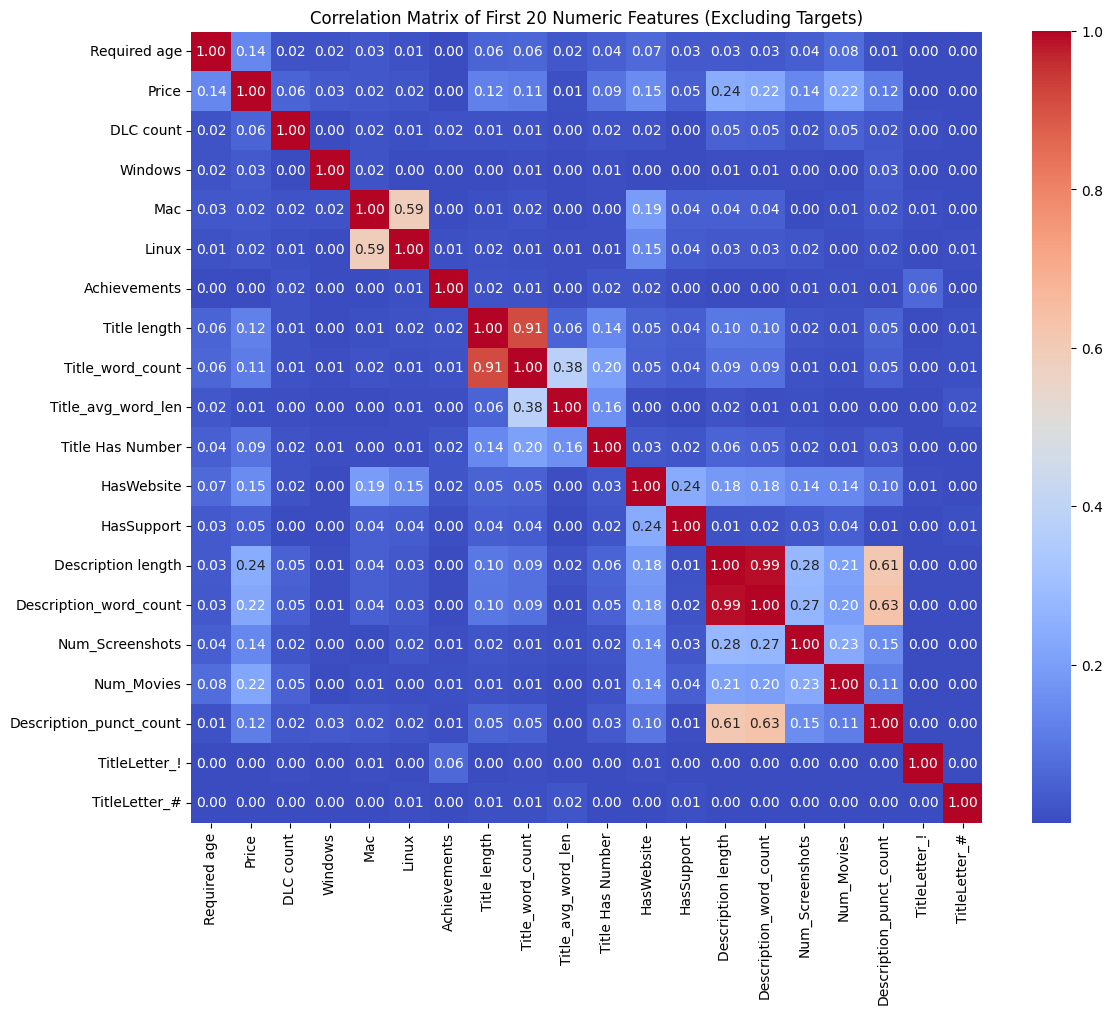

In [137]:
def plot_feature_correlations(df, top_n=10, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    # Select numeric columns and drop excluded ones
    numeric_df = df.select_dtypes(include='number').drop(columns=exclude_columns, errors='ignore')

    # Take the first n columns
    first_n_features = numeric_df.columns[:top_n]
    selected_df = numeric_df[first_n_features]

    # Compute absolute correlation matrix
    corr_matrix = selected_df.corr().abs()

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"Correlation Matrix of First {top_n} Numeric Features (Excluding Targets)")
    plt.tight_layout()
    plt.show()


plot_feature_correlations(df, top_n=20, exclude_columns=targets)

In [138]:
def remove_highly_correlated_features(df, threshold=0.80, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    numeric_df = df.select_dtypes(include=['number']).drop(columns=exclude_columns, errors='ignore')
    corr_matrix = numeric_df.corr().abs()

    # Only consider upper triangle without diagonal
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns to drop: for each column, if any correlation above threshold in upper triangle, mark it
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

    print(f"Removing {len(to_drop)} highly correlated features with threshold > {threshold}")
    print("Sample of features removed (up to 20):")
    print(to_drop[:20])

    return df.drop(columns=to_drop), to_drop

df, dropped_cols = remove_highly_correlated_features(df, 0.8, targets)

print(f"Final number of features (columns): {df.shape[1]}")
print(f"Number of samples (rows): {df.shape[0]}")
print("First 10 feature names:")
print(list(df.columns[:20]))

Removing 130 highly correlated features with threshold > 0.8
Sample of features removed (up to 20):
['Title_word_count', 'Description_word_count', 'DescLetter_ع', 'DescLetter_♨', 'DescLetter_マ', 'DescLetter_万', 'DescLetter_中', 'DescLetter_产', 'DescLetter_享', 'DescLetter_介', 'DescLetter_偏', 'DescLetter_八', 'DescLetter_动', 'DescLetter_即', 'DescLetter_命', 'DescLetter_好', 'DescLetter_少', 'DescLetter_就', 'DescLetter_崇', 'DescLetter_平']
Final number of features (columns): 1523
Number of samples (rows): 53178
First 10 feature names:
['Required age', 'Price', 'DLC count', 'Windows', 'Mac', 'Linux', 'Achievements', 'Title length', 'Title_avg_word_len', 'Title Has Number', 'HasWebsite', 'HasSupport', 'Description length', 'Num_Screenshots', 'Num_Movies', 'Description_punct_count', 'TitleLetter_!', 'TitleLetter_#', 'TitleLetter_$', "TitleLetter_'"]


In [117]:
print("================Basic Info======================")

print(df.info)

print("================Table Shape======================")

rows, cols = df.shape
print(f"Rows: {rows}, Columns: {cols}")

print("================Table Head======================")
      
print(df.head(4))

================Basic Info======================
<bound method DataFrame.info of        Required age     Price  DLC count   Windows       Mac     Linux  \
0         -0.159124  1.014314  -0.045341  0.012266 -0.546654 -0.421239   
1         -0.159124 -0.699456  -0.045341  0.012266  1.829312 -0.421239   
2         -0.159124 -0.788752  -0.045341  0.012266  1.829312 -0.421239   
3         -0.159124 -0.788752  -0.045341  0.012266 -0.546654 -0.421239   
4         -0.159124  0.202528   0.016154  0.012266 -0.546654 -0.421239   
...             ...       ...        ...       ...       ...       ...   
53173     -0.159124 -0.519059  -0.045341  0.012266 -0.546654 -0.421239   
53174     -0.159124 -0.338662  -0.045341  0.012266 -0.546654  2.373950   
53175     -0.159124  1.014314  -0.045341  0.012266 -0.546654 -0.421239   
53176     -0.159124  2.818281   0.385121  0.012266 -0.546654 -0.421239   
53177     -0.159124 -0.068067  -0.045341  0.012266 -0.546654 -0.421239   

       Achievements  Title len

Targets to predict:

Number of positive reviews
Number of Negative Reviews
Metacritic Score

Positive Ratio	Positive / (Negative + Positive)
Review Difference	Positive - Negative

Review Category
Review Category (Simplified)

Estimated number of owners
Total Number of Reviews
Average playtime (All time)


Double check and reset all the targets

In [139]:
all_targets = Main_targets + additional_targets + numerical_targets + categorical_targets
unique_targets = set(all_targets)  # Remove duplicates

existing_cols = [col for col in unique_targets if col in df.columns]
missing_cols = [col for col in unique_targets if col not in df.columns]

print("Existing columns in df:")
print(existing_cols)

print("\nMissing columns in df:")
print(missing_cols)

#Reset the features now that some got removed

targets = set(Main_targets + additional_targets)

features = [col for col in df.columns if col not in targets]

Existing columns in df:
['Total Review Count', 'Negative Review Count', 'Metacritic Score', 'Positive Review Count', 'Avg Playtime (hrs)', 'Detailed Review Category', 'Review Count Difference', 'Positivity Rate', 'Estimated Owners', 'Simplified Review Category']

Missing columns in df:
[]


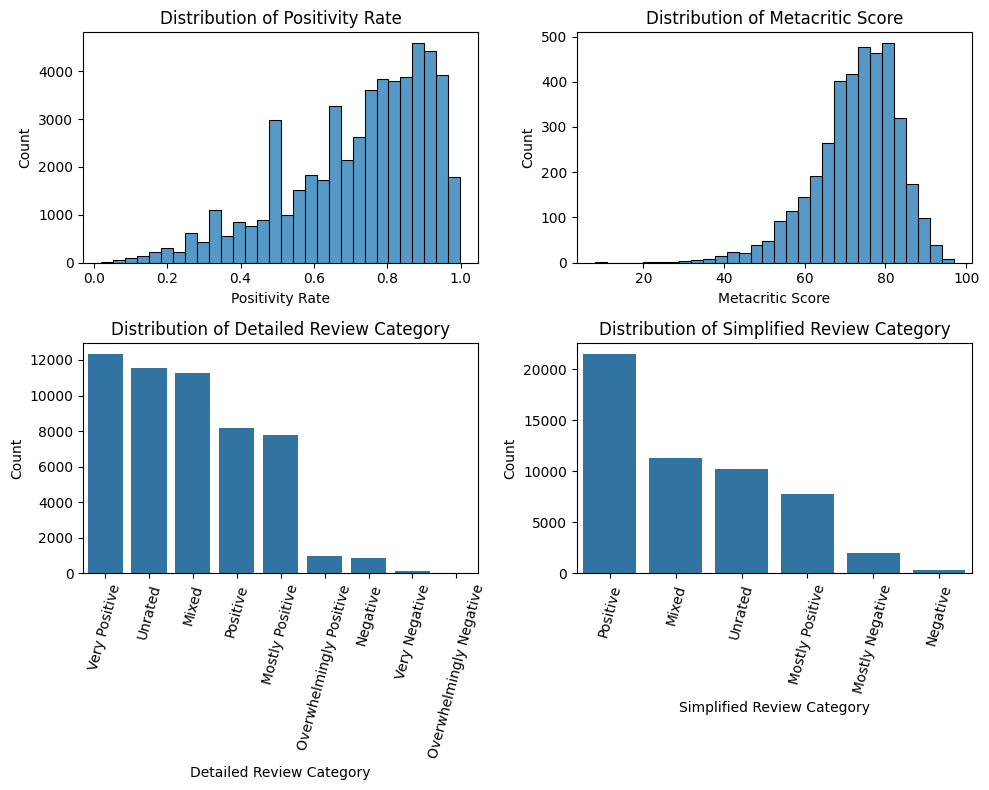

In [76]:
def quick_plot_distributions_fast(df, numerical_targets, categorical_targets, max_sample=10000):
    total_targets = numerical_targets + categorical_targets
    n_targets = len(total_targets)
    cols = 2
    rows = math.ceil(n_targets / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, target in enumerate(total_targets):
        ax = axes[i]
        if target in numerical_targets:
            data = df[target].dropna()

            # Special case: exclude zeros for Metacritic Score
            if target == 'Metacritic Score':
                data = data[data != 0]

            # Downsample if needed
            if len(data) > max_sample:
                data = data.sample(max_sample, random_state=42)

            sns.histplot(data, kde=False, ax=ax, bins=30)
            ax.set_title(f"Distribution of {target}")
            ax.set_xlabel(target)
            ax.set_ylabel("Count")

        elif target in categorical_targets:
            counts = df[target].value_counts()
            sns.barplot(x=counts.index, y=counts.values, ax=ax)
            ax.set_title(f"Distribution of {target}")
            ax.set_xlabel(target)
            ax.set_ylabel("Count")
            ax.tick_params(axis='x', rotation=75)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

main_numerical_targets = [
    'Positivity Rate', 'Metacritic Score',
]

main_categorical_targets = [
    'Detailed Review Category', 'Simplified Review Category'
]

data = df[list(targets)].dropna()
if len(data) > 100000:
    data = data.sample(100000, random_state=42)

# Now plot only main targets
quick_plot_distributions_fast(data, main_numerical_targets, main_categorical_targets, max_sample=100000)

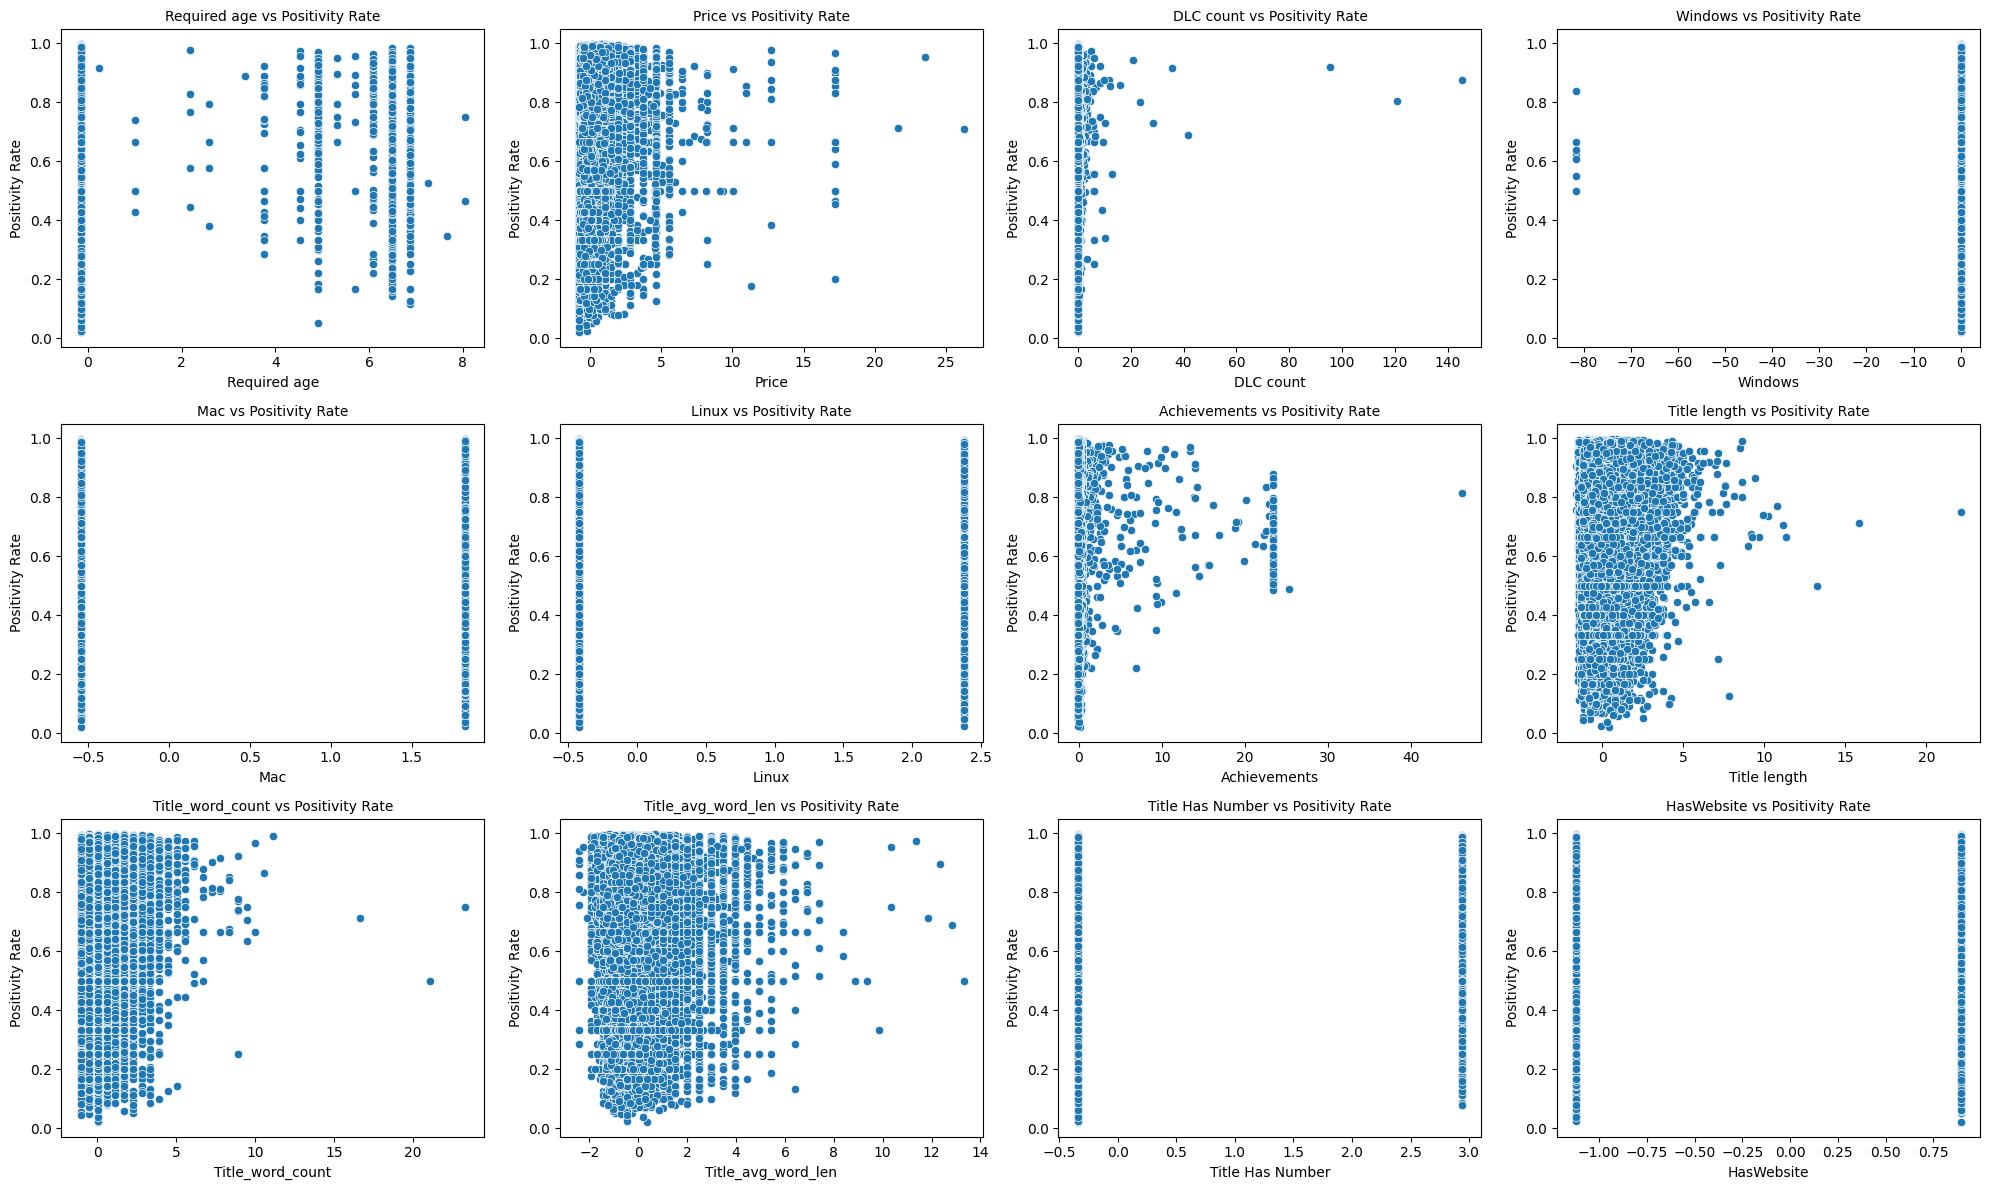

In [78]:
def plot_features_vs_target(df, target='Positivity Rate', n_features=12):
    # Select numeric features, exclude the target and non-numeric columns
    numeric_features = df.select_dtypes(include=['number']).columns.drop([target], errors='ignore')
    
    # Select the first n_features for plotting
    feature_columns = numeric_features[:n_features]

    # Setup subplot grid
    cols = 4
    rows = math.ceil(len(feature_columns) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    # Plot each feature against the target
    for i, feature in enumerate(feature_columns):
        sns.scatterplot(data=df, x=feature, y=target, ax=axes[i])
        axes[i].set_title(f"{feature} vs {target}", fontsize=10)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target)

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_features_vs_target(df, target='Positivity Rate', n_features=12)

In [142]:
#Double Checked for Long names to make sure there are no weird features

N = 10  # how many you want to print
longest_columns = sorted(df.columns, key=len, reverse=True)[:N]
print(f"Top {N} longest column names:")
for col in longest_columns:
    print(f"{len(col):>3} characters → {col}")

shortest_columns = sorted(df.columns, key=len)[:N]
print(f"\nTop {N} shortest column names:")
for col in shortest_columns:
    print(f"{len(col):>3} characters → {col}")

Top 10 longest column names:
 43 characters → Developers_united independent entertainment
 43 characters → Publishers_united independent entertainment
 37 characters → Categories_cross-platform multiplayer
 37 characters → Categories_partial controller support
 37 characters → Categories_tracked controller support
 37 characters → Publishers_bandai namco entertainment
 37 characters → Publishers_forever entertainment s. a
 36 characters → Categories_shared/split screen co-op
 35 characters → Categories_steam turn notifications
 35 characters → Categories_valve anti-cheat enabled

Top 10 shortest column names:
  3 characters → Mac
  5 characters → Price
  5 characters → Linux
  7 characters → Windows
  7 characters → Tags_2d
  7 characters → Tags_3d
  7 characters → Tags_vr
  8 characters → Tags_fps
  8 characters → Tags_pve
  8 characters → Tags_pvp


Lets look at the p-values

C:\Users\wille\AppData\Local\Temp\ipykernel_15736\2699404867.py:22: UserWarning: Glyph 12298 (\N{LEFT DOUBLE ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wille\AppData\Local\Temp\ipykernel_15736\2699404867.py:22: UserWarning: Glyph 12302 (\N{LEFT WHITE CORNER BRACKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wille\AppData\Local\Temp\ipykernel_15736\2699404867.py:22: UserWarning: Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wille\AppData\Local\Temp\ipykernel_15736\2699404867.py:22: UserWarning: Glyph 12354 (\N{HIRAGANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wille\AppData\Local\Temp\ipykernel_15736\2699404867.py:22: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wille\AppData\Local\Temp\ipykernel_15736\2699404867.py:22: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER

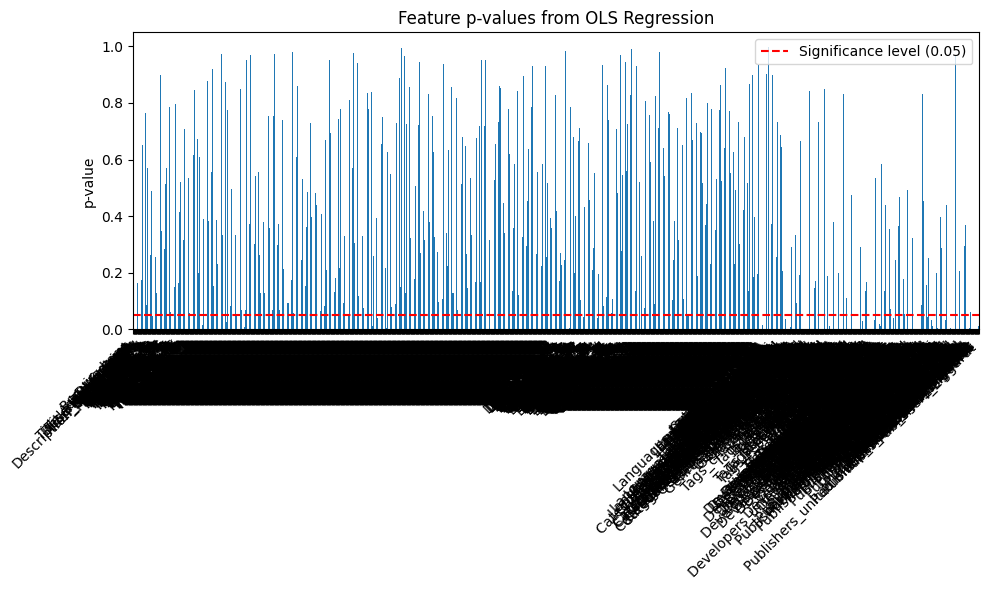

In [140]:
def plot_feature_pvalues(df, features, target, alpha=0.05):
    numeric_features = [col for col in features if pd.api.types.is_numeric_dtype(df[col])]
    X = df[numeric_features]
    y = df[target]

    # Add intercept for OLS
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    # Extract p-values (skip the intercept 'const')
    pvalues = model.pvalues.drop('const')

    # Plot
    plt.figure(figsize=(10, 6))
    pvalues.plot(kind='bar')
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance level (0.05)')
    plt.ylabel('p-value')
    plt.title('Feature p-values from OLS Regression')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Filter significant features
    significant_features = pvalues[pvalues < alpha].index.tolist()

    return significant_features, model.summary()

significant_features, summary = plot_feature_pvalues(df, features, 'Positivity Rate')



In [145]:
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1) if n > k + 1 else r2

Lets do Mixed feature selection first to get an idea of what works well

In [177]:
def mixed_stepwise_selection(df, all_features, target_col, cv=5, min_adj_r2_improvement=0.001, plot=False, verbose=True):
    y = df[target_col].values
    X_all = df[all_features]
    n_samples = len(y)

    selected_features = []
    remaining_features = list(all_features)

    metrics = {
        'r2_cv': [], 'adj_r2_cv': [],
        'mae_cv': [], 'mse_cv': [], 'rmse_cv': [],
        'num_features': []
    }

    best_scores = {
        'r2': {'score': -np.inf, 'features': [], 'model': None},
        'mae': {'score': np.inf, 'features': [], 'model': None},
        'mse': {'score': np.inf, 'features': [], 'model': None},
        'rmse': {'score': np.inf, 'features': [], 'model': None}
    }

    iteration = 0
    improved = True
    prev_adj_r2 = -np.inf

    if verbose:
        print(f"\nStarting Mixed Stepwise Selection for target: '{target_col}'")
        print("-" * 60)

    while improved and (remaining_features or len(selected_features) > 1):
        improved = False
        iteration += 1

        # --- Forward step: add feature improving adj R² most ---
        best_candidate = None
        best_candidate_adj_r2 = -np.inf

        for feat in remaining_features:
            trial_features = selected_features + [feat]
            model = LinearRegression()
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            y_pred_cv = cross_val_predict(model, X_all[trial_features], y, cv=kf)

            r2 = r2_score(y, y_pred_cv)
            adj_r2_val = adjusted_r2(r2, n_samples, len(trial_features))

            if adj_r2_val > best_candidate_adj_r2:
                best_candidate_adj_r2 = adj_r2_val
                best_candidate = feat

        if best_candidate and best_candidate_adj_r2 > prev_adj_r2:
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            improved = True
            if verbose:
                print(f"[Iteration {iteration}] Added feature: {best_candidate} | CV Adj R²: {best_candidate_adj_r2:.4f}")

        # --- Backward step: remove feature if adj R² improves ---
        if len(selected_features) > 1:
            X_sm = sm.add_constant(X_all[selected_features])
            ols_model = sm.OLS(y, X_sm).fit()
            pvalues = ols_model.pvalues.drop('const', errors='ignore')
            worst_feat = pvalues.idxmax()

            trial_features = [f for f in selected_features if f != worst_feat]
            model = LinearRegression()
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            y_pred_cv = cross_val_predict(model, X_all[trial_features], y, cv=kf)

            r2 = r2_score(y, y_pred_cv)
            adj_r2_val = adjusted_r2(r2, n_samples, len(trial_features))

            if adj_r2_val > prev_adj_r2:
                selected_features.remove(worst_feat)
                remaining_features.append(worst_feat)
                improved = True
                if verbose:
                    print(f"[Iteration {iteration}] Removed feature: {worst_feat} (p={pvalues[worst_feat]:.4f}) | CV Adj R² improved to {adj_r2_val:.4f}")
            else:
                if verbose:
                    print(f"[Iteration {iteration}] Did NOT remove feature: {worst_feat} (p={pvalues[worst_feat]:.4f}), no CV Adj R² improvement")

        # --- Evaluate current feature set ---
        if selected_features:
            model = LinearRegression()
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            y_pred_cv = cross_val_predict(model, X_all[selected_features], y, cv=kf)

            r2_cv = r2_score(y, y_pred_cv)
            mae_cv = mean_absolute_error(y, y_pred_cv)
            mse_cv = mean_squared_error(y, y_pred_cv)
            rmse_cv = np.sqrt(mse_cv)
            adj_r2_cv = adjusted_r2(r2_cv, n_samples, len(selected_features))

            metrics['r2_cv'].append(r2_cv)
            metrics['adj_r2_cv'].append(adj_r2_cv)
            metrics['mae_cv'].append(mae_cv)
            metrics['mse_cv'].append(mse_cv)
            metrics['rmse_cv'].append(rmse_cv)
            metrics['num_features'].append(len(selected_features))

            # Update best scores
            final_model = LinearRegression().fit(X_all[selected_features], y)
            if r2_cv > best_scores['r2']['score']:
                best_scores['r2'].update({'score': r2_cv, 'features': list(selected_features), 'model': final_model})
            if mae_cv < best_scores['mae']['score']:
                best_scores['mae'].update({'score': mae_cv, 'features': list(selected_features), 'model': final_model})
            if mse_cv < best_scores['mse']['score']:
                best_scores['mse'].update({'score': mse_cv, 'features': list(selected_features), 'model': final_model})
            if rmse_cv < best_scores['rmse']['score']:
                best_scores['rmse'].update({'score': rmse_cv, 'features': list(selected_features), 'model': final_model})

            if verbose:
                print(f"[Iteration {iteration}] Current features: {selected_features}")
                print(f"R² CV: {r2_cv:.4f} | Adj R² CV: {adj_r2_cv:.4f} | MAE CV: {mae_cv:.4f} | MSE CV: {mse_cv:.4f} | RMSE CV: {rmse_cv:.4f}\n")

            # Early stopping check based on adjusted R² improvement
            delta_adj_r2 = adj_r2_cv - prev_adj_r2
            if delta_adj_r2 < min_adj_r2_improvement:
                if verbose:
                    print(f"🔹 Stopping early: Adj R² improvement {delta_adj_r2:.6f} < threshold {min_adj_r2_improvement}")
                break

            prev_adj_r2 = adj_r2_cv

    if verbose:
        print("-" * 60)
        print("Best subsets by metric:")
        for metric, data in best_scores.items():
            print(f"  {metric.upper()}: {data['score']:.4f} with {len(data['features'])} features")

    if plot and len(metrics['num_features']) > 1:
        plt.figure(figsize=(14, 10))
        plt.subplot(2, 2, 1)
        plt.plot(metrics['num_features'], metrics['adj_r2_cv'], marker='s', label='Adj R² (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('Adjusted R²')
        plt.title('Adjusted R² vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(metrics['num_features'], metrics['mae_cv'], marker='o', label='MAE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('MAE')
        plt.title('MAE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(metrics['num_features'], metrics['mse_cv'], marker='o', label='MSE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('MSE')
        plt.title('MSE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(metrics['num_features'], metrics['rmse_cv'], marker='o', label='RMSE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('RMSE')
        plt.title('RMSE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return best_scores, metrics, selected_features

def mixed_stepwise_selection_classification(
    df, all_features, target_col, cv=3,
    min_f1_improvement=0.005, max_iter=50,
    verbose=True, plot=False
):
    y = df[target_col].values
    X_all = df[all_features]
    remaining_features = list(all_features)
    selected_features = []
    best_f1 = 0
    iteration = 0
    improved = True

    metrics = {
        'macro_f1_cv': [],
        'num_features': []
    }

    if verbose:
        print(f"\nStarting Mixed Stepwise Selection for classification target: '{target_col}'")
        print("-" * 60)

    while improved and (remaining_features or len(selected_features) > 1) and iteration < max_iter:
        improved = False
        iteration += 1
        print(f"\n🔁 Iteration {iteration}/{max_iter}")
        print(f"📌 Remaining features: {len(remaining_features)}")
        if verbose and len(remaining_features) <= 20:
            print("🔍 Candidate features to evaluate:")
            print(", ".join(remaining_features))
            
        # --- Forward step ---
        best_candidate = None
        best_candidate_f1 = -np.inf

        for feat in remaining_features:
            trial_features = selected_features + [feat]
            model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, max_iter=200)
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            f1 = cross_val_score(model, X_all[trial_features], y, cv=kf, scoring='f1_macro').mean()

            if f1 > best_candidate_f1:
                best_candidate_f1 = f1
                best_candidate = feat

        if best_candidate and best_candidate_f1 > best_f1 + min_f1_improvement:
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            if verbose:
                print(f"[Iteration {iteration}] Added: {best_candidate} | CV F1: {best_candidate_f1:.4f} | ΔF1: {best_candidate_f1 - best_f1:.6f}")
            best_f1 = best_candidate_f1
            improved = True

        # --- Backward step ---
        if len(selected_features) > 1:
            worst_feat = None
            worst_f1 = best_f1

            for feat in selected_features:
                trial_features = [f for f in selected_features if f != feat]
                model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, max_iter=200)
                kf = KFold(n_splits=cv, shuffle=True, random_state=42)
                f1 = cross_val_score(model, X_all[trial_features], y, cv=kf, scoring='f1_macro', n_jobs=-1).mean()

                if f1 > worst_f1 + min_f1_improvement:
                    worst_f1 = f1
                    worst_feat = feat

            if worst_feat:
                selected_features.remove(worst_feat)
                remaining_features.append(worst_feat)
                if verbose:
                    print(f"[Iteration {iteration}] Removed: {worst_feat} | CV F1: {worst_f1:.4f} | ΔF1: {worst_f1 - best_f1:.6f}")
                best_f1 = worst_f1
                improved = True

        # --- Log metrics ---
        if selected_features:
            metrics['macro_f1_cv'].append(best_f1)
            metrics['num_features'].append(len(selected_features))

        if verbose:
            print(f"[Iteration {iteration}] Features: {selected_features} | Best F1: {best_f1:.4f}")

        if iteration % 5 == 0 and verbose:
            print(f"--- Still improving at iteration {iteration} ---")

    if verbose:
        print("-" * 60)
        print(f"Final selected features for classification target '{target_col}': {selected_features}")
        print(f"Best CV Macro F1: {best_f1:.4f}")

    if plot and len(metrics['num_features']) > 1:
        plt.figure(figsize=(8, 6))
        plt.plot(metrics['num_features'], metrics['macro_f1_cv'], marker='o', label='Macro F1 (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('Macro F1 Score')
        plt.title(f'Macro F1 vs Number of Features ({target_col})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return selected_features

In [181]:
results = {'mixed': {}}

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

done_targets = ['Total Review Count', 'Negative Review Count', 'Metacritic Score', 'Positive Review Count', 'Avg Playtime (hrs)', 'Detailed Review Category', 'Estimated Owners', 'Positivity Rate', 'Review Count Difference', 'Simplified Review Category']  #If you don;t want to redo everything when things break

targets2 = [t for t in targets if t not in done_targets]

for target in targets2:
    if target in categorical_targets:
        print(f"\n=== Classification Mixed Stepwise Selection for target: {target} ===")
        selected_feats = mixed_stepwise_selection_classification(df_train, features, target, verbose=True, plot=True)
        # For classification, store only 'features' (no detailed metrics)
        results['mixed'][target] = {'features': selected_feats}
        print(f"Selected features for {target}: {selected_feats}")
    else:
        print(f"\n=== Regression Mixed Stepwise Selection for target: {target} ===")
        best_scores, metrics, selected_feats = mixed_stepwise_selection(df_train, features, target, verbose=True, plot=True)
        # For regression, store full best_scores dict
        results['mixed'][target] = {'scores': best_scores, 'metrics': metrics, 'features': selected_feats}
        print(f"Selected features for {target}: {selected_feats}")

You can uncomment the "results" here. This was just because my compuiter crash and I didn't want to rerun everythuing so I simply rewrote/copied everything I had from my presentation

In [185]:
results = {
    'mixed': {
        'Total Review Count': {'features': ['Categories_remote play on phone', 'Categories_valve anti-cheat enabled', 'Num_Movies', 'Tags_online co-op', 'Languages_polish', 'Categories_steam workshop', 'Required age', 'Categories_in-app purchases', 'Release_year']},
        'Negative Review Count': {'features': ['Num_Movies', 'Categories_valve anti-cheat enabled', 'Categories_remote play on phone', 'Categories_in-app purchases', 'Developers_valve', 'Tags_co-op', 'Required age', 'Categories_remote play together']},
        'Metacritic Score':{'features': ['Release_year', 'Tags_count', 'Languages_french', 'Categories_remote play on tv', 'Price', 'Tags_great soundtrack', 'Required age', 'Categories_family sharing', 'Publishers_electronic arts', 'Publishers_devolver digital', 'Tags_singleplayer', 'Num_Movies']},
        'Positive Review Count':{'features': ['Categories_remote play on phone', 'Categories_valve anti-cheat enabled', 'Num_Movies', 'Tags_online co-op', 'Categories_steam workshop', 'Required age', 'Languages_polish', 'Categories_in-app purchases']},
        'Average Playtime':{'features': ['Categories_steam trading cards', 'Genres_indie', 'Num_Movies', 'Categories_valve anti-cheat enabled', 'Genres_utilities', 'Categories_steam workshop', 'Categories_remote play on phone', 'Tags_open world', 'Categories_in-app purchases', 'Developers_valve', 'Price', 'Release_year']},
        'Review Count Difference':{'features': ['Categories_valve anti-cheat enabled', 'Categories_remote play on phone', 'Num_Movies', 'Categories_steam workshop', 'Tags_online co-op', 'Required age', 'Languages_czech', 'Categories_in-app purchases']},
        'Positivity Rate':{'features': ['Tags_count', 'Categories_steam cloud', 'Genres_count', 'Mac', 'Tags_visual novel', 'Categories_full controller support', 'Tags_pixel graphics', 'Tags_survival', 'Developers_hede', 'Tags_realistic', 'Languages_japanese', 'Publishers_united independent entertainment', 'Tags_violent', 'Tags_great soundtrack', 'Developers_reforged group', 'Categories_steam achievements']},    
    }
}


for target in targets:
    print(f"\n📊 Final Test Evaluation for: {target}")
    
    try:
        # Get best features from mixed stepwise results
        best_features = results['mixed'][target]['features']

        # Prepare train/test data
        X_train = df_train[best_features]
        y_train = df_train[target]
        X_test = df_test[best_features]
        y_test = df_test[target]

        # Drop NaNs
        train_data = pd.concat([X_train, y_train], axis=1).dropna()
        test_data = pd.concat([X_test, y_test], axis=1).dropna()

        X_train = train_data[best_features]
        y_train = train_data[target]
        X_test = test_data[best_features]
        y_test = test_data[target]

        # Choose model
        is_classification = y_train.dtype == 'object' or target in categorical_targets
        if is_classification:
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            print(f"✅ Test Accuracy: {score:.4f}")
        else:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = r2_score(y_test, y_pred)
            print(f"✅ Test R² Score: {score:.4f}")

    except Exception as e:
        print(f"❌ Failed to evaluate {target}: {e}")


📊 Final Test Evaluation for: Total Review Count
✅ Test R² Score: -4.7848

📊 Final Test Evaluation for: Negative Review Count
✅ Test R² Score: -12.5880

📊 Final Test Evaluation for: Metacritic Score
✅ Test R² Score: 0.2563

📊 Final Test Evaluation for: Positive Review Count
✅ Test R² Score: -6.6985

📊 Final Test Evaluation for: Avg Playtime (hrs)
❌ Failed to evaluate Avg Playtime (hrs): 'Avg Playtime (hrs)'

📊 Final Test Evaluation for: Detailed Review Category
❌ Failed to evaluate Detailed Review Category: 'Detailed Review Category'

📊 Final Test Evaluation for: Review Count Difference
✅ Test R² Score: -4.7238

📊 Final Test Evaluation for: Positivity Rate
✅ Test R² Score: 0.0903

📊 Final Test Evaluation for: Estimated Owners
❌ Failed to evaluate Estimated Owners: 'Estimated Owners'

📊 Final Test Evaluation for: Simplified Review Category
❌ Failed to evaluate Simplified Review Category: 'Simplified Review Category'


In [184]:
results = {
    'mixed': {
        'Total Review Count': {'features': ['Categories_remote play on phone', 'Categories_valve anti-cheat enabled', 'Num_Movies', 'Tags_online co-op', 'Languages_polish', 'Categories_steam workshop', 'Required age', 'Categories_in-app purchases', 'Release_year']},
        'Negative Review Count': {'features': ['Num_Movies', 'Categories_valve anti-cheat enabled', 'Categories_remote play on phone', 'Categories_in-app purchases', 'Developers_valve', 'Tags_co-op', 'Required age', 'Categories_remote play together']},
        'Metacritic Score':{'features': ['Release_year', 'Tags_count', 'Languages_french', 'Categories_remote play on tv', 'Price', 'Tags_great soundtrack', 'Required age', 'Categories_family sharing', 'Publishers_electronic arts', 'Publishers_devolver digital', 'Tags_singleplayer', 'Num_Movies']},
        'Positive Review Count':{'features': ['Categories_remote play on phone', 'Categories_valve anti-cheat enabled', 'Num_Movies', 'Tags_online co-op', 'Categories_steam workshop', 'Required age', 'Languages_polish', 'Categories_in-app purchases']},
        'Average Playtime':{'features': ['Categories_steam trading cards', 'Genres_indie', 'Num_Movies', 'Categories_valve anti-cheat enabled', 'Genres_utilities', 'Categories_steam workshop', 'Categories_remote play on phone', 'Tags_open world', 'Categories_in-app purchases', 'Developers_valve', 'Price', 'Release_year']},
        'Review Count Difference':{'features': ['Categories_valve anti-cheat enabled', 'Categories_remote play on phone', 'Num_Movies', 'Categories_steam workshop', 'Tags_online co-op', 'Required age', 'Languages_czech', 'Categories_in-app purchases']},
        'Positivity Rate':{'features': ['Tags_count', 'Categories_steam cloud', 'Genres_count', 'Mac', 'Tags_visual novel', 'Categories_full controller support', 'Tags_pixel graphics', 'Tags_survival', 'Developers_hede', 'Tags_realistic', 'Languages_japanese', 'Publishers_united independent entertainment', 'Tags_violent', 'Tags_great soundtrack', 'Developers_reforged group', 'Categories_steam achievements']},    
    }
}

top_n = 5  # Number of top features to print

print("\n=================================")
print("Mixed Stepwise Selection Top Features")
print("=================================")

for target, result in results['mixed'].items():
    print(f"\n=== Target: {target} ===")
    
    # If regression result (has 'scores' dict)
    if 'scores' in result:
        scores = result['scores']
        for metric_name, metric_data in scores.items():
            features = metric_data.get('features', [])[:top_n]
            print(f"{metric_name.upper()} Top {top_n} Features: {features}")
    else:
        # Classification case: only 'features' list
        features = result.get('features', [])[:top_n]
        print(f"Selected Top {top_n} Features: {features}")


Mixed Stepwise Selection Top Features

=== Target: Total Review Count ===
Selected Top 5 Features: ['Categories_remote play on phone', 'Categories_valve anti-cheat enabled', 'Num_Movies', 'Tags_online co-op', 'Languages_polish']

=== Target: Negative Review Count ===
Selected Top 5 Features: ['Num_Movies', 'Categories_valve anti-cheat enabled', 'Categories_remote play on phone', 'Categories_in-app purchases', 'Developers_valve']

=== Target: Metacritic Score ===
Selected Top 5 Features: ['Release_year', 'Tags_count', 'Languages_french', 'Categories_remote play on tv', 'Price']

=== Target: Positive Review Count ===
Selected Top 5 Features: ['Categories_remote play on phone', 'Categories_valve anti-cheat enabled', 'Num_Movies', 'Tags_online co-op', 'Categories_steam workshop']

=== Target: Average Playtime ===
Selected Top 5 Features: ['Categories_steam trading cards', 'Genres_indie', 'Num_Movies', 'Categories_valve anti-cheat enabled', 'Genres_utilities']

=== Target: Review Count Dif

Decision Trees and Random Forest next in order to build a better model

In [1]:
def run_random_forest_analysis(df, target_col, excluded_columns, top_n=10, verbose=True):
    if target_col == 'Metacritic score':
        df = filter_valid_target(df, 'Metacritic score')

    is_classification = df[target_col].dtype == 'object' or target_col in categorical_targets

    features = [col for col in df.columns if col not in excluded_columns and col != target_col]

    X = df[features].copy()
    y = df[target_col].copy()

    data = pd.concat([X, y], axis=1).dropna()
    X = data[features]
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if is_classification:
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if is_classification:
        score = accuracy_score(y_test, y_pred)
        score_name = "Accuracy"
    else:
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        mae = mean_absolute_error(y_test, y_pred)
        score = r2
        score_name = "R²"

    importances = model.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    top_features = feature_importances.head(top_n)['feature'].tolist()

    if verbose:
        print(f"\n📊 Evaluation for Target: {target_col}")
        if is_classification:
            print(f"✅ {score_name}: {score:.4f}")
        else:
            print(f"✅ R²: {r2:.4f}")
            print(f"📉 MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
        print("⭐ Top features:")
        print(feature_importances.head(top_n))
        print("-" * 60)

    return {
        'target': target_col,
        'score': score,
        'score_name': score_name,
        'top_features': top_features,
        'model': model,
        'feature_importances': feature_importances
    }

Cross Validation


In [200]:

from sklearn.model_selection import cross_val_score
def cross_validate_top_n_features(df, target_col, excluded_columns, 
                                  top_n_list=[5, 10, 20, 50, 75, 100, 150], 
                                  cv=5, min_improvement=0.01):
    scores = []
    best_score = -float('inf')
    prev_best_score = -float('inf')
    
    for top_n in top_n_list:
        result = run_random_forest_analysis(df, target_col, excluded_columns, top_n=top_n, verbose=False)
        
        top_features = result['top_features']
        X = df[top_features].copy()
        y = df[target_col].copy()
        
        data = pd.concat([X, y], axis=1).dropna()
        X = data[top_features]
        y = data[target_col]
        
        is_classification = y.dtype == 'object' or target_col in categorical_targets
        
        if is_classification:
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            scoring = 'accuracy'
            score = cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
            print(f"Top {top_n} features → CV Accuracy: {score:.4f}")
        else:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            
            r2 = cross_val_score(model, X, y, cv=cv, scoring='r2').mean()
            neg_mse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error').mean()
            neg_mae = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error').mean()
            
            mse = -neg_mse
            rmse = mse**0.5
            mae = -neg_mae

            print(f"Top {top_n} features → CV R²: {r2:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
            score = r2  # used for early stopping
        
        scores.append((top_n, score, result))
        
        # Early stopping check
        improvement = score - prev_best_score
        if improvement < min_improvement:
            print(f"🔹 Early stopping: Improvement {improvement:.6f} < threshold {min_improvement}")
            break
        
        prev_best_score = score
    
    best_n, best_score, best_result = max(scores, key=lambda x: x[1])
    print(f"\n✅ Best number of features: {best_n} → CV Score: {best_score:.4f}")
    
    return best_result

I created a variable called "TargetsIWant" to avoid redoing all the targets every time things broke or crashed. Comment it out if you wish

In [203]:
# List of target columns
Main_targets = [
    'Positivity Rate', 'Metacritic Score', 'Detailed Review Category',
    'Simplified Review Category', 'Review Count Difference'
]
additional_targets = [
    'Estimated Owners', 'Positive Review Count', 'Negative Review Count', 
    'Total Review Count', 'Avg Playtime (hrs)'
]

numerical_targets = [
    'Positivity Rate', 'Metacritic Score', 'Positive Review Count', 
    'Negative Review Count', 'Total Review Count', 'Avg Playtime (hrs)', 
    'Review Count Difference'
]

categorical_targets = [
    'Detailed Review Category', 'Simplified Review Category', 'Estimated Owners'
]

targets = set(Main_targets + additional_targets)

targetsIWant = [
    'Positivity Rate',
    'Metacritic Score',
    'Detailed Review Category',
    'Simplified Review Category',
    'Estimated Owners',
]

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Store all results
cv_results = []

# Loop through targets
for target in targetsIWant:
    print(f"\n🔍 Cross-validating for: {target}")
    try:
        result = cross_validate_top_n_features(
            df=df_train,
            target_col=target,
            excluded_columns= [t for t in targets if t != target],
            top_n_list=[5, 10, 20, 50, 75, 100, 150],
            cv=5
        )
        cv_results.append(result)
    except Exception as e:
        print(f"❌ Failed for {target}: {e}")


🔍 Cross-validating for: Positivity Rate
Top 5 features → CV R²: 0.0473 | MSE: 0.0358 | RMSE: 0.1892 | MAE: 0.1509
Top 10 features → CV R²: 0.1212 | MSE: 0.0330 | RMSE: 0.1817 | MAE: 0.1453
Top 20 features → CV R²: 0.1792 | MSE: 0.0308 | RMSE: 0.1756 | MAE: 0.1404
Top 50 features → CV R²: 0.2125 | MSE: 0.0296 | RMSE: 0.1720 | MAE: 0.1370
Top 75 features → CV R²: 0.2189 | MSE: 0.0294 | RMSE: 0.1713 | MAE: 0.1363
🔹 Early stopping: Improvement 0.006406 < threshold 0.01

✅ Best number of features: 75 → CV Score: 0.2189

🔍 Cross-validating for: Metacritic Score
Top 5 features → CV R²: 0.2165 | MSE: 285.1518 | RMSE: 16.8864 | MAE: 6.5565
Top 10 features → CV R²: 0.3182 | MSE: 248.1396 | RMSE: 15.7524 | MAE: 6.6779
Top 20 features → CV R²: 0.3673 | MSE: 230.2795 | RMSE: 15.1750 | MAE: 6.3792
Top 50 features → CV R²: 0.3987 | MSE: 218.7903 | RMSE: 14.7916 | MAE: 6.1698
Top 75 features → CV R²: 0.4026 | MSE: 217.3813 | RMSE: 14.7439 | MAE: 6.1410
🔹 Early stopping: Improvement 0.003886 < thresho

C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 5 features → CV Accuracy: 0.6566


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 10 features → CV Accuracy: 0.6834


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 20 features → CV Accuracy: 0.6949


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 50 features → CV Accuracy: 0.6961
🔹 Early stopping: Improvement 0.001152 < threshold 0.01

✅ Best number of features: 50 → CV Score: 0.6961


In [206]:
from sklearn.metrics import r2_score, accuracy_score

for target, result in zip(targetsIWant, cv_results):
    print(f"\n📊 Final Test Evaluation for: {target}")
    
    try:
        # Get best features from cross-validation
        best_features = result['top_features']

        # Prepare train and test data
        X_train = df_train[best_features]
        y_train = df_train[target]
        X_test = df_test[best_features]
        y_test = df_test[target]

        # Drop NaNs
        train_data = pd.concat([X_train, y_train], axis=1).dropna()
        test_data = pd.concat([X_test, y_test], axis=1).dropna()

        X_train = train_data[best_features]
        y_train = train_data[target]
        X_test = test_data[best_features]
        y_test = test_data[target]

        # Choose model
        is_classification = y_train.dtype == 'object' or target in categorical_targets
        if is_classification:
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            print(f"✅ Test Accuracy: {score:.4f}")
        else:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = r2_score(y_test, y_pred)
            print(f"✅ Test R² Score: {score:.4f}")

    except Exception as e:
        print(f"❌ Failed to evaluate {target}: {e}")



📊 Final Test Evaluation for: Positivity Rate
✅ Test R² Score: 0.2297

📊 Final Test Evaluation for: Metacritic Score
✅ Test R² Score: 0.4233

📊 Final Test Evaluation for: Detailed Review Category
✅ Test Accuracy: 0.4459

📊 Final Test Evaluation for: Simplified Review Category
✅ Test Accuracy: 0.5102

📊 Final Test Evaluation for: Estimated Owners
✅ Test Accuracy: 0.6951


In [209]:
def cross_validate_top_n_features(df, target_col, excluded_columns, 
                                  top_n_list=[5, 10, 20, 50, 75, 100, 150], 
                                  cv=5, min_improvement=0.01):
    scores = []
    prev_best_score = -float('inf')

    metrics = {
        'r2': [],
        'mse': [],
        'mae': [],
        'rmse': [],
        'accuracy': [],
        'num_features': []
    }
    
    for top_n in top_n_list:
        result = run_random_forest_analysis(df, target_col, excluded_columns, top_n=top_n, verbose=False)
        top_features = result['top_features']
        X = df[top_features].copy()
        y = df[target_col].copy()

        data = pd.concat([X, y], axis=1).dropna()
        X = data[top_features]
        y = data[target_col]

        is_classification = y.dtype == 'object' or target_col in categorical_targets
        
        if is_classification:
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            scoring = 'accuracy'
            score = cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
            metrics['accuracy'].append(score)
            print(f"Top {top_n} features → CV Accuracy: {score:.4f}")
        else:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            
            r2 = cross_val_score(model, X, y, cv=cv, scoring='r2').mean()
            neg_mse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error').mean()
            neg_mae = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error').mean()
            
            mse = -neg_mse
            rmse = mse**0.5
            mae = -neg_mae
            
            metrics['r2'].append(r2)
            metrics['mse'].append(mse)
            metrics['rmse'].append(rmse)
            metrics['mae'].append(mae)
            print(f"Top {top_n} features → CV R²: {r2:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
            score = r2  # for early stopping

        metrics['num_features'].append(top_n)
        scores.append((top_n, score, result))
        
        improvement = score - prev_best_score
        if improvement < min_improvement:
            print(f"🔹 Early stopping: Improvement {improvement:.6f} < threshold {min_improvement}")
            break
        prev_best_score = score
    
    best_n, best_score, best_result = max(scores, key=lambda x: x[1])
    print(f"\n✅ Best number of features: {best_n} → CV Score: {best_score:.4f}")
    
    return best_result, metrics

In [210]:
cv_results2 = []
all_metrics2 = {}

for target in targetsIWant:
    print(f"\n🔍 Cross-validating for: {target}")
    try:
        best_result, metrics = cross_validate_top_n_features(
            df=df_train,
            target_col=target,
            excluded_columns=[t for t in targets if t != target],
            top_n_list=[5, 10, 20, 50, 75, 100, 150],
            cv=5
        )
        cv_results2.append(best_result)
        all_metrics2[target] = metrics
    except Exception as e:
        print(f"❌ Failed for {target}: {e}")


🔍 Cross-validating for: Positivity Rate
Top 5 features → CV R²: 0.0473 | MSE: 0.0358 | RMSE: 0.1892 | MAE: 0.1509
Top 10 features → CV R²: 0.1212 | MSE: 0.0330 | RMSE: 0.1817 | MAE: 0.1453
Top 20 features → CV R²: 0.1792 | MSE: 0.0308 | RMSE: 0.1756 | MAE: 0.1404
Top 50 features → CV R²: 0.2125 | MSE: 0.0296 | RMSE: 0.1720 | MAE: 0.1370
Top 75 features → CV R²: 0.2189 | MSE: 0.0294 | RMSE: 0.1713 | MAE: 0.1363
🔹 Early stopping: Improvement 0.006406 < threshold 0.01

✅ Best number of features: 75 → CV Score: 0.2189

🔍 Cross-validating for: Metacritic Score
Top 5 features → CV R²: 0.2165 | MSE: 285.1518 | RMSE: 16.8864 | MAE: 6.5565
Top 10 features → CV R²: 0.3182 | MSE: 248.1396 | RMSE: 15.7524 | MAE: 6.6779
Top 20 features → CV R²: 0.3673 | MSE: 230.2795 | RMSE: 15.1750 | MAE: 6.3792
Top 50 features → CV R²: 0.3987 | MSE: 218.7903 | RMSE: 14.7916 | MAE: 6.1698
Top 75 features → CV R²: 0.4026 | MSE: 217.3813 | RMSE: 14.7439 | MAE: 6.1410
🔹 Early stopping: Improvement 0.003886 < thresho

C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 5 features → CV Accuracy: 0.6566


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 10 features → CV Accuracy: 0.6834


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 20 features → CV Accuracy: 0.6949


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 50 features → CV Accuracy: 0.6961
🔹 Early stopping: Improvement 0.001152 < threshold 0.01

✅ Best number of features: 50 → CV Score: 0.6961


In [211]:
def plot_feature_selection_metrics(metrics_dict):
    for target, metrics in metrics_dict.items():
        num_features = metrics['num_features']
        
        plt.figure(figsize=(14, 10))
        plt.suptitle(f"Cross-Validation Metrics vs Number of Features\nTarget: {target}", fontsize=16)

        is_classification = 'accuracy' in metrics and len(metrics['accuracy']) > 0
        
        if is_classification:
            # Accuracy plot for classification
            plt.plot(num_features, metrics['accuracy'], marker='o', label='Accuracy', color='tab:blue')
            plt.xlabel('Number of Features')
            plt.ylabel('Accuracy')
            plt.title('Accuracy vs Number of Features')
            plt.grid(True)
            plt.legend()
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        
        else:
            # Regression: plot R², MAE, MSE, RMSE
            plt.subplot(2, 2, 1)
            plt.plot(num_features, metrics['r2'], marker='o', label='R²', color='tab:green')
            plt.title('R² vs Number of Features')
            plt.xlabel('Number of Features')
            plt.ylabel('R²')
            plt.grid(True)

            plt.subplot(2, 2, 2)
            plt.plot(num_features, metrics['mae'], marker='o', label='MAE', color='tab:orange')
            plt.title('MAE vs Number of Features')
            plt.xlabel('Number of Features')
            plt.ylabel('MAE')
            plt.grid(True)

            plt.subplot(2, 2, 3)
            plt.plot(num_features, metrics['mse'], marker='o', label='MSE', color='tab:red')
            plt.title('MSE vs Number of Features')
            plt.xlabel('Number of Features')
            plt.ylabel('MSE')
            plt.grid(True)

            plt.subplot(2, 2, 4)
            plt.plot(num_features, metrics['rmse'], marker='o', label='RMSE', color='tab:purple')
            plt.title('RMSE vs Number of Features')
            plt.xlabel('Number of Features')
            plt.ylabel('RMSE')
            plt.grid(True)

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

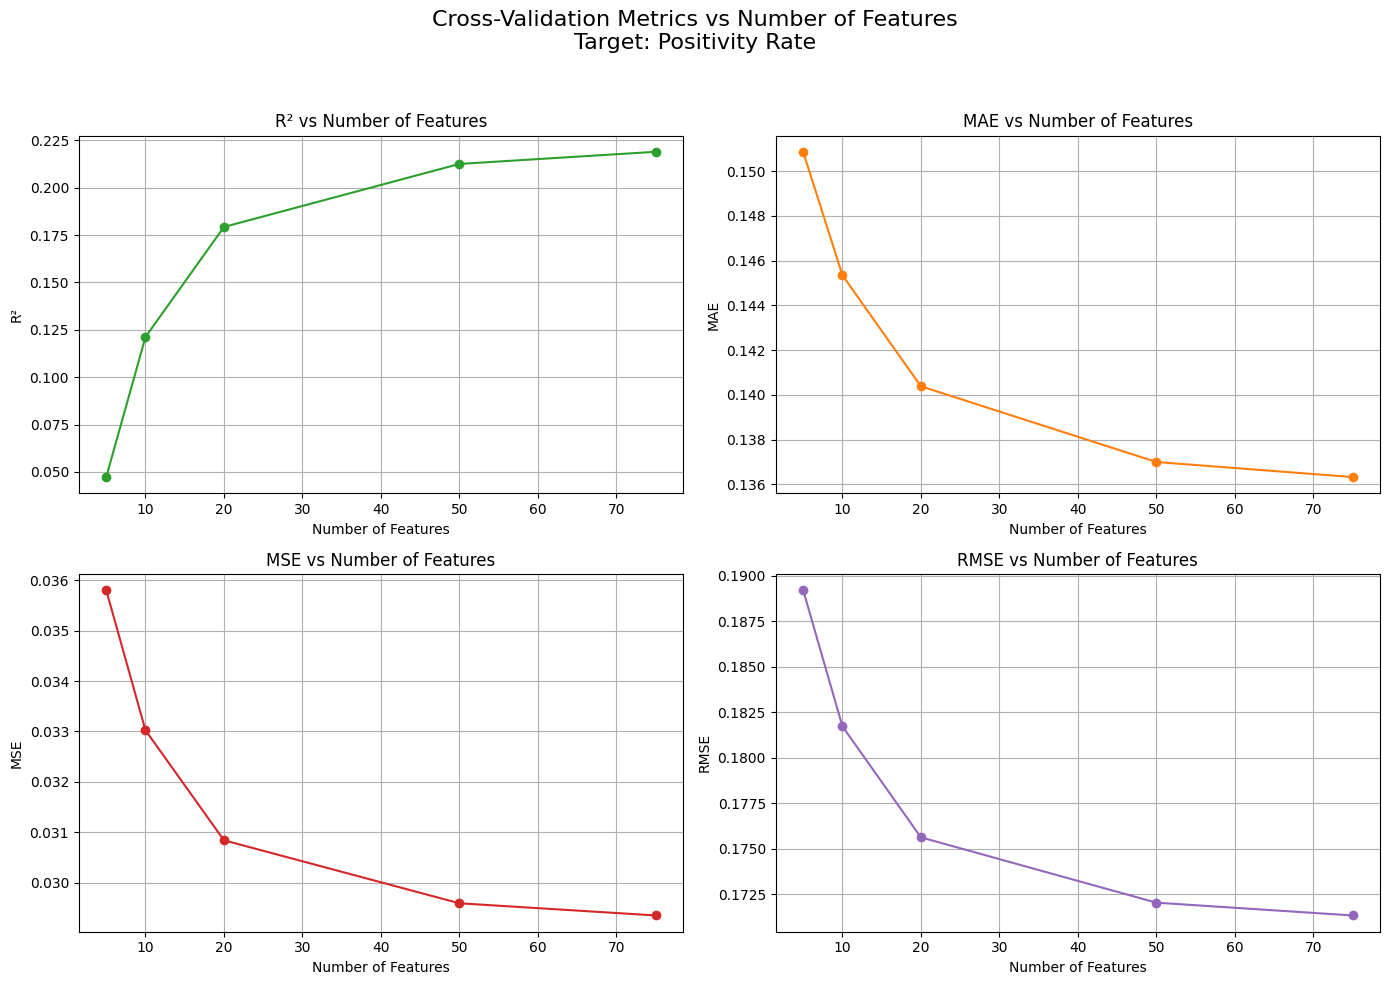

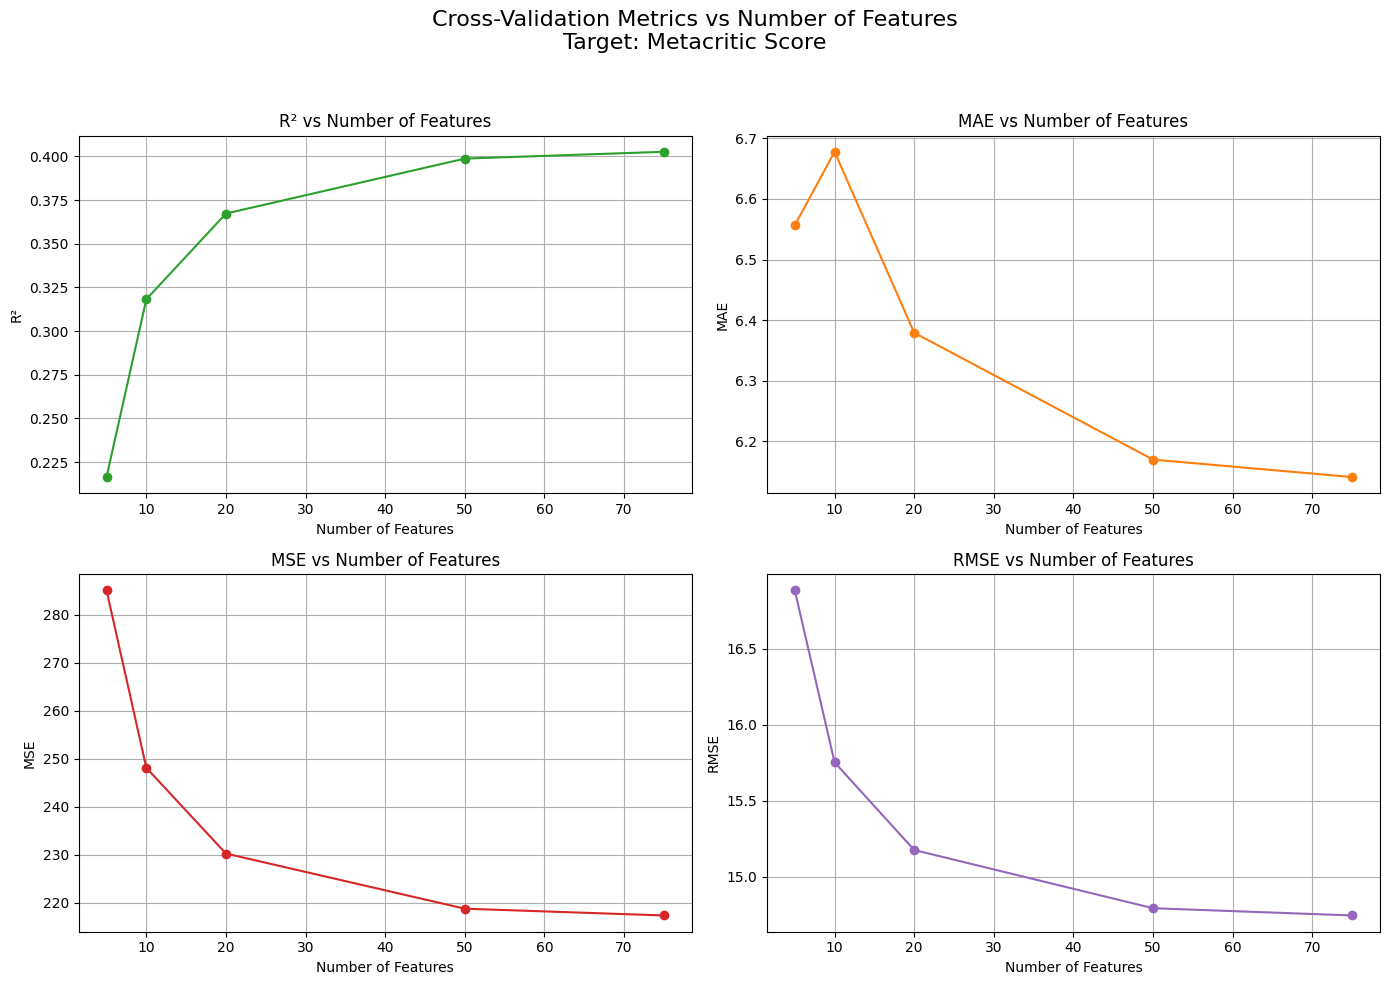

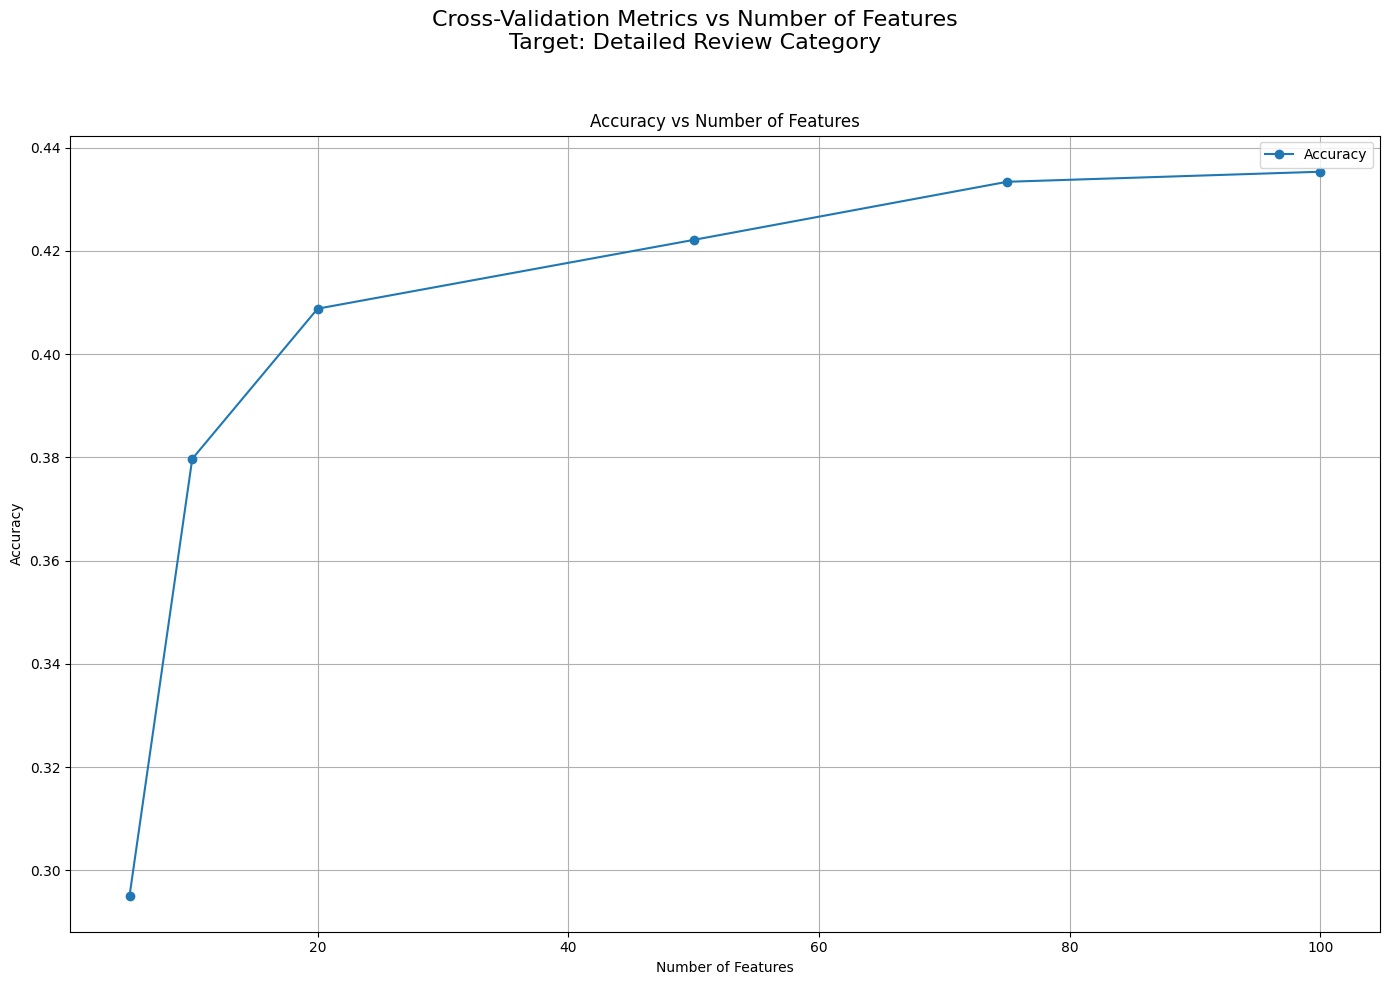

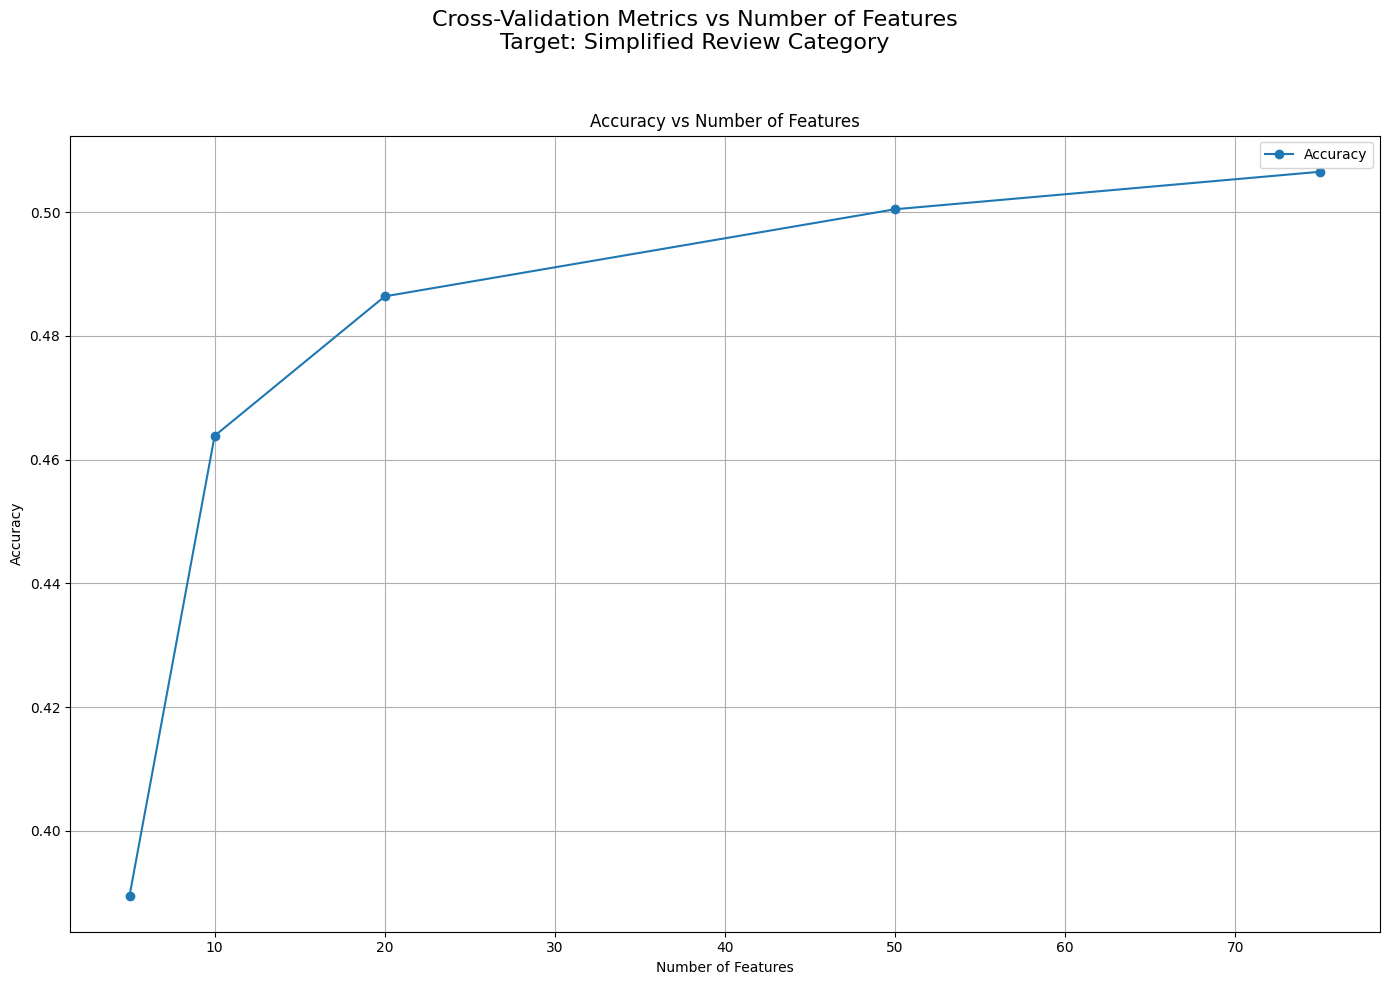

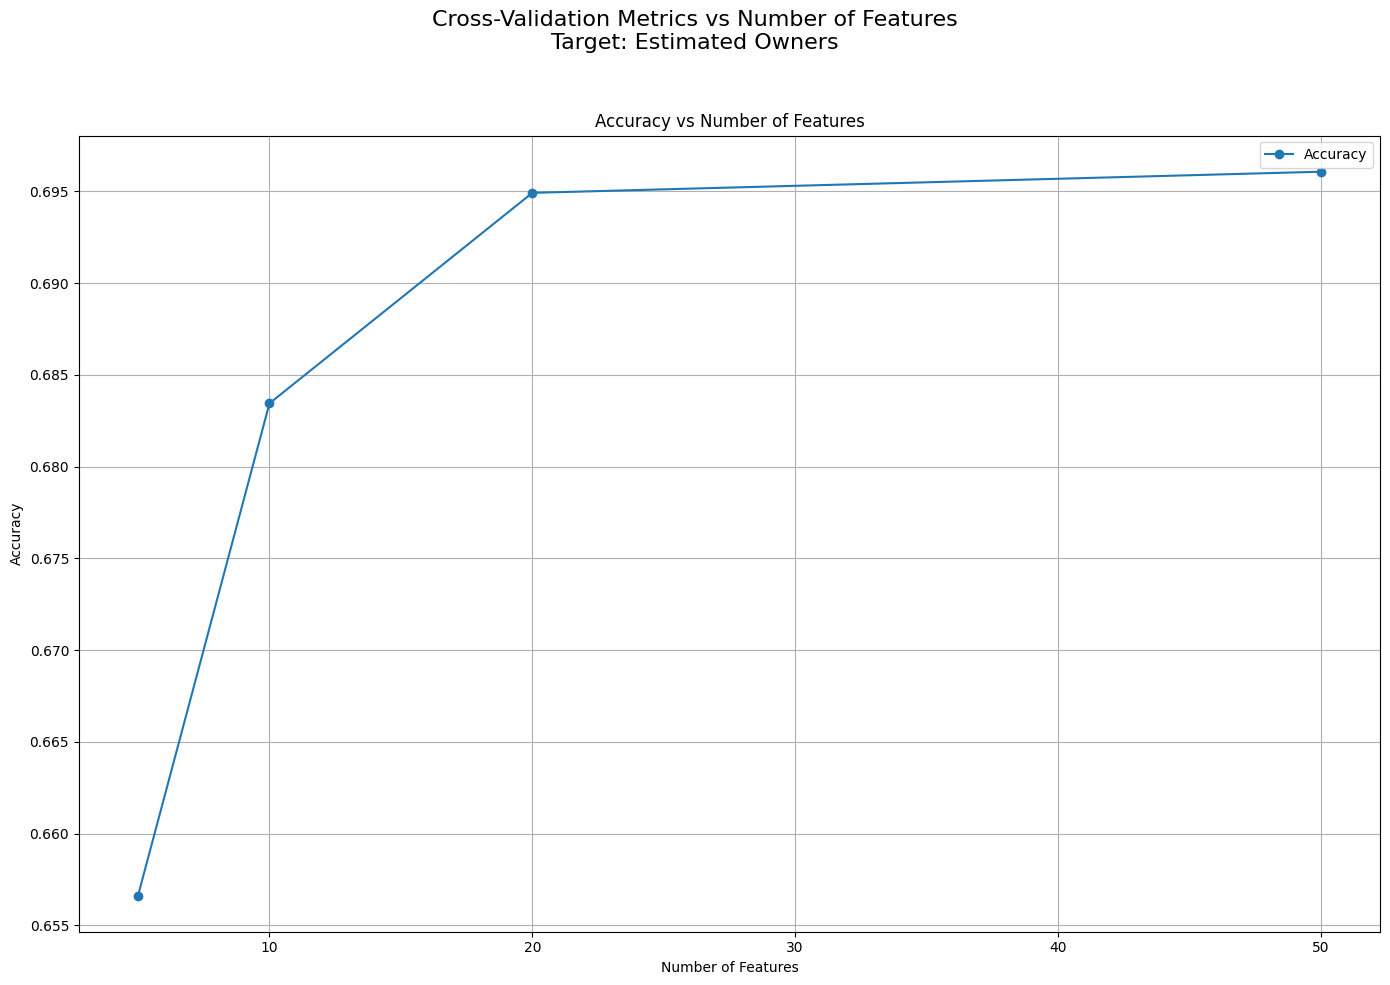

In [212]:
plot_feature_selection_metrics(all_metrics2)

In [214]:

for result in cv_results2:
    target = result['target']
    top_features = result['top_features'][:5]  # Get top 3
    print(f"🎯 Target: {target}")
    for i, feat in enumerate(top_features, start=1):
        print(f"   {i}. {feat}")
    print("-" * 40)


🎯 Target: Positivity Rate
   1. Tags_count
   2. Achievements
   3. Description length
   4. Price
   5. Title length
----------------------------------------
🎯 Target: Metacritic Score
   1. Release_year
   2. Categories_remote play on tv
   3. Price
   4. Tags_count
   5. Categories_steam trading cards
----------------------------------------
🎯 Target: Detailed Review Category
   1. Description length
   2. Release_year
   3. Description_punct_count
   4. Price
   5. Title_avg_word_len
----------------------------------------
🎯 Target: Simplified Review Category
   1. Description length
   2. Description_punct_count
   3. Release_year
   4. Price
   5. Title length
----------------------------------------
🎯 Target: Estimated Owners
   1. Release_year
   2. Description length
   3. Price
   4. Description_punct_count
   5. Title length
----------------------------------------
